# Auditing Allocative Bias
## Kate Kenny 
### CS 0451 

In this blog post, we are going to examine algorithmic bias through an audit. Using data from the American Community Survey's Public Use Microdata Sample (PUMS). I will perform an audit on racial bias in a machine learning model that predicts whether or not an individual in employed.To do this, I will begin by downloading data and training a model to make such predictions. Then, we will examine some of the different measures of fairness like predictive parity and error rate before discussing how the model could be biased and what implications that could have in deployment and beyond. This audit will only consider data from New York State. 

To begin, let's download the data and get the problem set up. 

In [48]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np
from matplotlib import pyplot as plt


STATE = "NY"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)


possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

is_white = acs_data["RAC1P"] == 1
is_black = acs_data["RAC1P"] == 2

acs_data = acs_data[is_white | is_black]
acs_date = acs_data.copy()

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

for obj in [features, label, group]:
  print(obj.shape)


(162498, 15)
(162498,)
(162498,)
[1 1 1 ... 1 1 1]


## Seperate training and testing data

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)


## Basic Descriptives

Let's first answer some basic questions about the test data that we are working with. For the sake of this blog, we are going to compare directly Black and white individuals and remove individuals with other listed races from the data frame. This is obviously an incomplete picture of New York's population but allows us to directly compare and analyze specific racial discrepencies between white individuals and Black individuals. Note that in the group column of the data frame, group 1 represents white individuals and group 2 represents Black individuals. 

In [102]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

df.shape[0]
y_train.mean()



,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,65.0,22.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False
1,24.0,20.0,5.0,0.0,1.0,0.0,1.0,3.0,4.0,2.0,1.0,2.0,2.0,1.0,1.0,1,True
2,41.0,21.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1,True
3,49.0,16.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,True
4,64.0,19.0,5.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129993,0.0,0.0,5.0,7.0,2.0,7.0,1.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,1.0,2,False
129994,29.0,21.0,5.0,0.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,1.0,1,True
129995,91.0,8.0,2.0,0.0,1.0,0.0,4.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,1,False
129996,42.0,21.0,1.0,0.0,2.0,0.0,4.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,1,True


There are 129,998 individuals in this data set. Of those individuals, the proportion of people with the target label 1 is .46618. 

In [53]:
df.groupby("group")["label"].mean()

group
1    0.474091
2    0.420689
Name: label, dtype: float64

Within each group, there is a difference in the proportion of individuals with the target label 1. Among white individuals (group 1), the proportion is .474091 and among Black individials (group 2) the proportion is .420689. This is a difference that is likely the result of many historical factors and centuries of systemic racism in the United States and certainly deserves much more focus than is covered in the scope of this blog post. However, for now let's continue. The following table is the result of breaking the data down by race and sex. Note that in the SEX category, 1.0 refers to male and 2.0 refers to female. 

<AxesSubplot: xlabel='group', ylabel='label'>

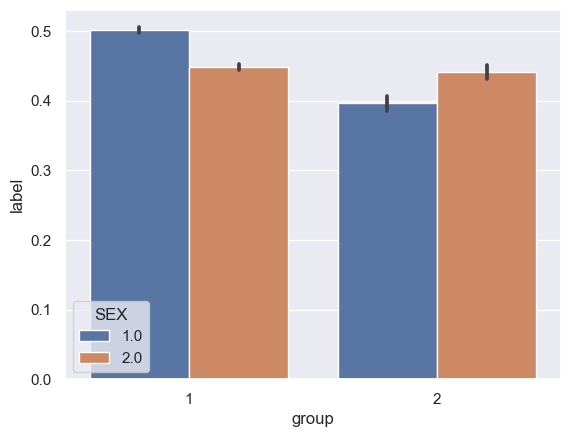

In [56]:
import seaborn as sns

intersectional = df.groupby(["group", "SEX"])["label"]
sns.set_theme()

sns.barplot(data=df, x="group", y="label", hue="SEX")

#CHANGE LABELS 

In this chart, it is interesting that white women and Black women have very similar rates of employment. However, white men have a higher rate of employment compared to white women and the opposite is true for Black men and women. 

## Build and train model

The model we are going to use is the Scitkit-Learn Decision Tree Classifier. Before finalizing our model, we can use cross validation to select the depth for the model in order to balance a high training score and limiting overfitting.  

0.8037772249581154
0.8101165062594978
0.7835820895522388


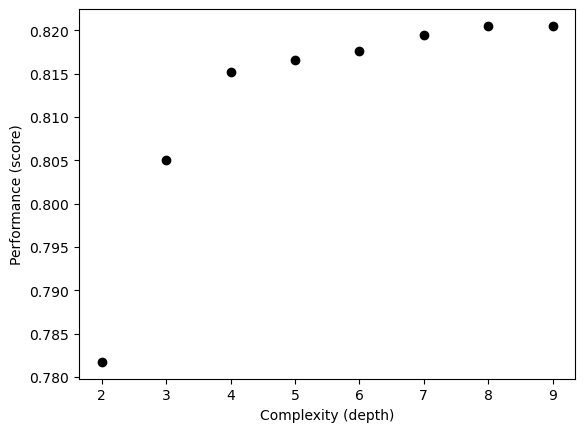

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

#cross validation to choose depth
from sklearn.model_selection import cross_val_score
np.random.seed(12345)

fig, ax = plt.subplots(1)

for d in range(2, 10):
    T = DecisionTreeClassifier(max_depth = d)
    m = cross_val_score(T, X_train, y_train, cv = 10).mean()
    ax.scatter(d, m, color = "black")
    # ax.scatter(d, T.score(X_test, y_test), color = "firebrick")

labs = ax.set(xlabel = "Complexity (depth)", ylabel = "Performance (score)")

It seems like a depth of 4 could be ideal as the score improvement slows down significantly when the depth continues to increase beyon 4. So, to prevent against overfitting it seems that 4 is the best choice. Given that, let's train our model on the available data before moving into testing. 

In [73]:
model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth = 4))
model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4))])

## Testing and Audit

Now that we have trained a model, let's use it on test data and do an audit surrounding the accuracy, fairness, and allocative bias in the results. 

In [76]:
y_hat = model.predict(X_test)

print("Overall accruacy:")
print((y_hat == y_test).mean())

Overall accruacy:
0.8151692307692308
Accuracy for white individuals
0.8174079284348735
Accuracy for Black individuals
0.8021770985974461


Initially, our model has an accuracy of .815 overall. 
Next, let's consider the general confusion matrix for this test data. 

In [77]:
from sklearn.metrics import confusion_matrix

#calculate false neg, false pos rates
confusion_matrix(y_test, y_hat, normalize = "true")


array([[0.79528736, 0.20471264],
       [0.16192053, 0.83807947]])

The false negative rate of our model is .1619 and the false positive rate of our model is .2047. 

Next, let's consider some of the mathematical measures of fairness that we have been working with in the context of this model. We can measure the calibration, error rate balance, and statistical parity. 

In [78]:
#calculate PPV
np.sum(y_test) / np.sum(y_hat)

0.9311216624529814

The overall positive predictive values (PPV) of the model is .9311. 

Now that we have some overall measures, let's dive deeper into the different measures of accuracy by group. 


In [85]:
print("Accuracy for white individuals")
print((y_hat == y_test)[group_test == 1].mean())
print("Accuracy for Black individuals")
print((y_hat == y_test)[group_test == 2].mean())

Accuracy for white individuals
0.8174079284348735
Accuracy for Black individuals
0.8021770985974461


When we group by race above, we can see that the accuracy for white individuals (.8174) is slightly higher than the accuracy for Black individuals (.8023). Next let's consider the positive predictive value for both groups. This is the number of predicted labels of 1 divided by the actual number of target labels 1. In other words, it's how often a positive prediction from the model is correct. 

In [86]:
print("PPV for white individuals")
print(np.sum(y_test[group_test == 1]) / np.sum(y_hat))
print("PPV for Black individuals")
print(np.sum(y_test[group_test == 2]) / np.sum(y_hat))

PPV for white individuals
0.806376025158784
PPV for Black individuals
0.12474563729419745


The PPV for white individuals is .8064 and for Black individuals it is .1247. This is an extreme difference and will be discussed further later in this post. 

In [82]:
#Confusion matrix for Black individuals 
confusion_matrix(y_test[group_test == 2], y_hat[group_test == 2], normalize = "true")

array([[0.78612927, 0.21387073],
       [0.17597627, 0.82402373]])

In [83]:
#Confusion matrix for white individuals
confusion_matrix(y_test[group_test == 1], y_hat[group_test == 1], normalize = "true")

array([[0.79700942, 0.20299058],
       [0.15974612, 0.84025388]])

The false negative rate for Black individuals is .1759 and the false positive rate is .2138. The false negative rate for white individuals is .1597 and the false positive rate is .2138. So this is not an extreme difference but the error rates are not completely balanced. 

The model would be calibrated if Black and white individuals who were predicted to be unemployed had the same chance of being unemployed. To calculate this, we want to take all the individuals who were predicted to be unemployed and calculate what percentage actually are by group.  

Above, we calculated this positive predictive value for the model and the results are striking.

In [141]:
df = pd.DataFrame(X_test, columns = features_to_use)

df["pred_label"] = 1* y_hat.tolist()
df["label"] = y_test.tolist()
df["race"] = group_test.tolist()



df.groupby(["race", "pred_label"])["label"].mean().reset_index(name = "mean")

#p = sns.barplot(data = means, x = "pred_label", y = "mean", hue = "race")

df

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,pred_label,label,race
0,84.0,15.0,2.0,0.0,2.0,0.0,4.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,False,False,1
1,95.0,16.0,2.0,6.0,1.0,0.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,False,False,1
2,55.0,19.0,5.0,0.0,1.0,0.0,1.0,3.0,4.0,2.0,1.0,2.0,2.0,1.0,1.0,False,False,1
3,66.0,18.0,5.0,0.0,1.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,False,True,2
4,59.0,16.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32495,84.0,21.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,False,False,1
32496,67.0,20.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,False,True,1
32497,50.0,16.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,True,True,1
32498,37.0,13.0,5.0,17.0,2.0,0.0,1.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,False,True,2


### Error rate balance

Error rate balance is a measure of fairness that is defined as the algorithm having equal error rates across racial groups. As we calculated above, the error rates across Black and white individuals are very different. Specifically, the 